In [1]:
# INSTALL REQUIRED LIBRARIES

!pip install pandas -q
!pip install pretty_midi -q
!pip install torch -q
!pip install scikit-learn -q
!pip install seaborn -q
!pip install tqdm -q


# IMPORT LIBRARIES

# Standard libraries
import os                               # For handling paths and files
import time                             # For measuring execution times
import copy                             # For making deep copies
import random                           # For random selection
from datetime import datetime           # For managing timestamps

# Analysis and visualization
import numpy as np                      # Numerical computation
import pandas as pd                     # Table data manipulation
import seaborn as sns                   # Statistical visualization
import matplotlib.pyplot as plt         # Plotting
import matplotlib.patches as patches    # Drawing geometric shapes
import matplotlib.lines as mlines       # Drawing custom lines

# MIDI processing libraries
import pretty_midi                      # Reading and writing MIDI files

# PyTorch (modeling and training)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split  # For managing datasets

# Visual training progress
from tqdm import tqdm                   # Progress bars

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Saving and loading objects like scalers
import joblib
from joblib import load

# Ignore non-critical warnings
import warnings
warnings.filterwarnings('ignore')

# Consistent random seed initialization
SEED_VAL = 99  
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use: ", device)

Device in use:  cuda


# ----------------------------------------------------  Definitions  -------------------------------------------------------------

In [3]:
def load_data_from_folder(folder_path: str, instrument_index: int = 0, verbose: bool = False):
    """
    Loads MIDI files from a folder, extracts musical events from a specific instrument,
    and normalizes duration and step values between events.

    Parameters:
    ----------
    folder_path : str
        Path to the folder containing MIDI files.
    instrument_index : int, optional
        Index of the instrument to process in each MIDI file (default is 0).
    verbose : bool, optional
        If True, prints information about the files being loaded.

    Returns:
    -------
    sequences : list[dict]
        List of sequences, each represented as a dictionary with the keys:
        'pitch', 'step' (normalized), 'duration' (normalized), and 'velocity'.
    """

    sequences = []
    file_count = 0  # Counter for processed files

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        file_count += 1
        file_path = os.path.join(folder_path, filename)

        # Load MIDI file
        pm = pretty_midi.PrettyMIDI(file_path)

        # Select instrument by index
        instrument = pm.instruments[instrument_index]
        instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

        if verbose:
            print(f'Loading MIDI file #{file_count} from {folder_path}: {instrument_name}')

        # Extract note information
        pitch = np.array([note.pitch for note in instrument.notes])
        velocity = np.array([note.velocity for note in instrument.notes])
        start = np.array([note.start for note in instrument.notes])
        end = np.array([note.end for note in instrument.notes])
        duration = end - start
        step = np.array([start[i] - start[i - 1] for i in range(1, len(start))])

        # Save the sequence (omit the first note to align step)
        track = {
            'pitch': pitch[1:],
            'step': step,
            'velocity': velocity[1:] / 127,  # Normalize to [0,1] range
            'duration': duration[1:]
        }
        sequences.append(track)

    # Concatenate all steps and durations for scaling
    all_step = np.concatenate([seq['step'] for seq in sequences]).reshape(-1, 1)
    all_duration = np.concatenate([seq['duration'] for seq in sequences]).reshape(-1, 1)

    # Apply MinMaxScaler to normalize to [0,1]
    scaler_step = MinMaxScaler().fit(all_step)
    scaler_duration = MinMaxScaler().fit(all_duration)

    # Save scalers for later use (e.g., during generation)
    os.makedirs("scalers", exist_ok=True)
    joblib.dump(scaler_step, "scalers/scaler_step.pkl")
    joblib.dump(scaler_duration, "scalers/scaler_duration.pkl")

    # Transform step and duration in each sequence
    for seq in sequences:
        seq['step'] = scaler_step.transform(seq['step'].reshape(-1, 1)).flatten()
        seq['duration'] = scaler_duration.transform(seq['duration'].reshape(-1, 1)).flatten()

    return sequences

In [4]:
class CreateDataset(Dataset):
    """
    Class to generate a PyTorch-compatible dataset from processed musical sequences.

    Each generated fragment consists of a fixed-length sequence that serves as input (`x`),
    and the next note as the target (`y_pitch`, `y_step`, `y_duration`, `y_velocity`).
    This allows training sequential models that predict the next note based on previous context.

    Attributes:
    ----------
    seq_len : int
        Length of the input sequences (excluding the target).
    fragments : list
        List of fragments (dictionaries with arrays of pitch, step, duration, velocity).
    """

    def __init__(self, sequences, seq_len=50):
        self.seq_len = seq_len
        self.fragments = []

        for seq in sequences:
            length = len(seq['pitch'])

            # Extract fragments of length seq_len + 1 (last value is the prediction target)
            for i in range(length - seq_len + 1):
                if i + seq_len + 1 <= length:
                    fragment = {
                        'pitch': seq['pitch'][i:i+seq_len+1],
                        'step': np.maximum(0, seq['step'][i:i+seq_len+1]),
                        'velocity': seq['velocity'][i:i+seq_len+1],
                        'duration': seq['duration'][i:i+seq_len+1]
                    }
                    self.fragments.append(fragment)

    def __len__(self):
        # Return the number of available fragments
        return len(self.fragments)

    def __getitem__(self, idx):
        # Retrieve the corresponding fragment
        fragment = self.fragments[idx]

        # Input sequence (everything except the last step, as we want to predict the next note)
        x = torch.stack([
            torch.tensor(fragment['pitch'][:-1], dtype=torch.long),
            torch.tensor(fragment['step'][:-1], dtype=torch.float),
            torch.tensor(fragment['duration'][:-1], dtype=torch.float),
            torch.tensor(fragment['velocity'][:-1], dtype=torch.float)
        ], dim=1)

        # Targets (last value of the sequence)
        y_pitch = torch.tensor(fragment['pitch'][-1], dtype=torch.long)
        y_step = torch.tensor(fragment['step'][-1], dtype=torch.float)
        y_duration = torch.tensor(fragment['duration'][-1], dtype=torch.float)
        y_velocity = torch.tensor(fragment['velocity'][-1], dtype=torch.float)

        return x, y_pitch, y_step, y_duration, y_velocity

In [5]:
class LSTMModel(nn.Module):
    """
    LSTM-based neural network model for musical sequence prediction.

    The model receives a sequence of musical events and produces:
    - A probability distribution for the next note (pitch) using classification.
    - Continuous values for step, duration, and velocity using regression.

    Parameters:
    -----------
    hidden_size : int
        Number of hidden units in each LSTM layer.
    lstm_layers : int
        Number of stacked LSTM layers.
    dropout : float
        Dropout probability between LSTM layers.
    pitch_embedding_dim : int
        Dimension of the pitch embedding.

    Components:
    -----------
    - Pitch embedding.
    - LSTM processing the full sequence.
    - Normalization (LayerNorm) of the last hidden state (h).
    - Two dense branches: one for classification (pitch) and one for regression (step, duration, velocity).
    """

    def __init__(self, hidden_size=512, lstm_layers=2, dropout=0.3, pitch_embedding_dim=40):
        super(LSTMModel, self).__init__()

        # Embedding
        self.pitch_embedding = nn.Embedding(num_embeddings=128, embedding_dim=pitch_embedding_dim)

        # Normalization of the LSTM hidden state
        self.norm = nn.LayerNorm(hidden_size)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=pitch_embedding_dim + 3,  # embedding size + step + duration + velocity
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            dropout=dropout,
            batch_first=True
        )

        # Classification head (pitch)
        self.fc_pitch = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 128)  # 128 possible MIDI classes (0–127)
        )

        # Regression head (step, duration, velocity)
        self.fc_regression = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3)  # 3 continuous outputs
        )

    def forward(self, x):
        """
        Runs model inference given an input sequence.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor with shape [batch_size, seq_len, 4].

        Returns:
        --------
        pitch_logits : torch.Tensor
            Pitch classification logits (shape: [batch_size, 128])
        velocity_pred : torch.Tensor
            Velocity prediction (shape: [batch_size])
        step_pred : torch.Tensor
            Step prediction (shape: [batch_size])
        duration_pred : torch.Tensor
            Duration prediction (shape: [batch_size])
        """
        device = x.device

        # Separate input variables
        pitch = x[:, :, 0].long()                         # [B, T]
        step = x[:, :, 1].unsqueeze(-1)                   # [B, T, 1]
        duration = x[:, :, 2].unsqueeze(-1)               # [B, T, 1]
        velocity = x[:, :, 3].unsqueeze(-1)               # [B, T, 1]

        # Pitch embedding
        pitch_emb = self.pitch_embedding(pitch)           # [B, T, pitch_embedding_dim]

        # Concatenate all inputs
        x_concat = torch.cat([pitch_emb, step, duration, velocity], dim=-1)  # [B, T, pitch_emb+3]

        # Pass through LSTM
        lstm_out, _ = self.lstm(x_concat)                 # [B, T, hidden_size]
        h = lstm_out[:, -1, :]                            # Last hidden state [B, hidden_size]
        h = self.norm(h)                                  # Normalization

        # Predictions
        pitch_logits = self.fc_pitch(h)                   # Pitch classification
        reg_outputs = self.fc_regression(h)               # Continuous predictions
        step_pred, duration_pred, velocity_pred = reg_outputs[:, 0], reg_outputs[:, 1], reg_outputs[:, 2]

        return pitch_logits, velocity_pred, step_pred, duration_pred

In [6]:
class MusicLoss(nn.Module):
    """
    Class that implements a loss function for the music generation model.

    Combines a classification loss for pitch (CrossEntropyLoss) and regression
    losses for step, duration, and velocity (L1Loss / MAE), with adjustable weights for each component.

    Parameters:
    ----------
    omega : float
        Weight for the pitch classification loss.
    alpha : float
        Weight for the step regression loss.
    beta : float
        Weight for the duration regression loss.
    gamma : float
        Weight for the velocity regression loss.
    """
    def __init__(self, omega=1.0, alpha=1.0, beta=1.0, gamma=1.0):
        super(MusicLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()    # Classification loss (pitch)
        self.mae = nn.L1Loss()             # Regression loss (step, duration, velocity)
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, pitch_logits, velocity_pred, step_pred, duration_pred, y_pitch, y_velocity, y_step, y_duration, x=None):
        """
        Computes the total loss and each component separately.

        Returns:
        -------
        total_loss : torch.Tensor
            Weighted sum of all losses.
        loss_pitch : torch.Tensor
            Classification loss for pitch.
        loss_step : torch.Tensor
            Regression loss for step.
        loss_duration : torch.Tensor
            Regression loss for duration.
        loss_velocity : torch.Tensor
            Regression loss for velocity.
        """
        # Compute individual losses
        loss_pitch = self.omega * self.ce(pitch_logits, y_pitch)
        loss_step = self.alpha * self.mae(step_pred, y_step)
        loss_duration = self.beta * self.mae(duration_pred, y_duration)
        loss_velocity = self.gamma * self.mae(velocity_pred, y_velocity)

        # Total loss
        total_loss = loss_pitch + loss_step + loss_duration + loss_velocity

        return total_loss, loss_pitch, loss_step, loss_duration, loss_velocity

In [7]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, device, total_epochs=40, early_stopping=True, patience=7, min_delta=0.005, min_epochs=10, save_path='best_model.pt'):
    """
    Trains the LSTM model for the mixed task of classification (pitch) and regression (step, duration, velocity).

    Parameters:
    ----------
    model : nn.Module
        LSTM model to be trained.
    dataloader_train : DataLoader
        Training set dataloader.
    dataloader_val : DataLoader
        Validation set dataloader.
    criterion : nn.Module
        Loss function.
    optimizer : torch.optim.Optimizer
        Optimizer to update weights.
    device : torch.device
        Device to run on ('cpu' or 'cuda').
    total_epochs : int
        Total number of training epochs.
    early_stopping : bool
        If True, stops training early if no improvement (see min_delta).
    patience : int
        Number of epochs without improvement before stopping (see early stopping).
    min_delta : float
        Minimum improvement required to be considered an improvement.
    min_epochs : int
        Minimum number of epochs before applying early stopping.
    save_path : str
        Path to save the best model.

    Returns:
    -------
    all_loss_train : list
        List of total training losses per epoch.
    all_loss_val : list
        List of total validation losses per epoch.
    model : nn.Module
        Model loaded with the best weights found during training.
    """
    all_loss_train, all_loss_val = [], []
    all_subloss_train = {'pitch': [], 'step': [], 'duration': [], 'velocity': []}
    all_subloss_val = {'pitch': [], 'step': [], 'duration': [], 'velocity': []}

    best_model_state = None
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(total_epochs):
        # Training
        model.train()
        epoch_loss_train = 0.0
        subloss_train = {'pitch': 0.0, 'step': 0.0, 'duration': 0.0, 'velocity': 0.0}

        loop = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{total_epochs}", ncols=100)
        for x, y_pitch, y_step, y_duration, y_velocity in loop:
            x = x.to(device).float()
            y_pitch = y_pitch.to(device)
            y_step = y_step.to(device)
            y_duration = y_duration.to(device)
            y_velocity = y_velocity.to(device)

            optimizer.zero_grad()
            pitch_logits, velocity_pred, step_pred, duration_pred = model(x)
            loss, lp, ls, ld, lv = criterion(pitch_logits, velocity_pred, step_pred, duration_pred, y_pitch, y_velocity, y_step, y_duration, x)

            # Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent explosion
            optimizer.step()

            epoch_loss_train += loss.item()
            subloss_train['pitch'] += lp.item()
            subloss_train['step'] += ls.item()
            subloss_train['duration'] += ld.item()
            subloss_train['velocity'] += lv.item()

        all_loss_train.append(epoch_loss_train / len(dataloader_train))
        for k in subloss_train:
            all_subloss_train[k].append(subloss_train[k] / len(dataloader_train))

        # Validation
        model.eval()
        epoch_loss_val = 0.0
        subloss_val = {'pitch': 0.0, 'step': 0.0, 'duration': 0.0, 'velocity': 0.0}

        with torch.no_grad():
            for x, y_pitch, y_step, y_duration, y_velocity in dataloader_val:
                x = x.to(device).float()
                y_pitch = y_pitch.to(device)
                y_step = y_step.to(device)
                y_duration = y_duration.to(device)
                y_velocity = y_velocity.to(device)

                pitch_logits, velocity_pred, step_pred, duration_pred = model(x)
                loss, lp, ls, ld, lv = criterion(pitch_logits, velocity_pred, step_pred, duration_pred, y_pitch, y_velocity, y_step, y_duration, x)

                epoch_loss_val += loss.item()
                subloss_val['pitch'] += lp.item()
                subloss_val['step'] += ls.item()
                subloss_val['duration'] += ld.item()
                subloss_val['velocity'] += lv.item()

        val_loss_avg = epoch_loss_val / len(dataloader_val)
        all_loss_val.append(val_loss_avg)
        for k in subloss_val:
            all_subloss_val[k].append(subloss_val[k] / len(dataloader_val))

        tqdm.write(f"Epoch {epoch+1}: Training Loss: {all_loss_train[-1]:.3f}, Validation Loss: {val_loss_avg:.3f}")
        if epoch % 5 == 0 or epoch == 1:
            tqdm.write('-' * 20)
            tqdm.write(f"Pitch: {lp.item():.2f}, Step: {ls.item():.4f}, Duration: {ld.item():.2f}, Velocity: {lv.item():.4f}")
            tqdm.write('-' * 20)

        # Save the best model. The model is overwritten each time a better one appears to resume training in case of failure.
        if val_loss_avg < best_val_loss - min_delta:
            best_val_loss = val_loss_avg
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            torch.save(best_model_state, save_path)
            tqdm.write(f"[Best model saved as: {save_path}]")
        else:
            patience_counter += 1
            if early_stopping and epoch + 1 >= min_epochs and patience_counter >= patience:
                tqdm.write("Early stopping triggered!")
                break

    # Plot: total loss per epoch
    plt.figure(figsize=(6, 4))
    plt.plot(all_loss_train, label='Training Loss')
    plt.plot(all_loss_val, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Total Loss per Epoch')
    plt.tight_layout()
    plt.show()

    # Plots: individual losses
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    var_names = ['pitch', 'step', 'duration', 'velocity']
    for i, ax in enumerate(axs.flat):
        var = var_names[i]
        ax.plot(all_subloss_train[var], label='Training')
        ax.plot(all_subloss_val[var], label='Val')
        ax.set_title(f'Loss: {var.capitalize()}')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return all_loss_train, all_loss_val, model

In [8]:
def generateSequence(model, seed, length=200, seq_len=50, device='cpu', sampling=True, temperature=1.0):
    """
    Generates a sequence of notes based on a seed using a trained model.

    Parameters:
    ----------
    model : nn.Module
        Trained sequential model to generate music.
    seed : torch.Tensor
        Initial seed sequence of shape [T, 4] used as initial context.
    length : int
        Number of notes to generate.
    seq_len : int
        Maximum context length for the model (the length it was trained with).
    device : str
        Execution device ('cpu' or 'cuda').
    sampling : bool
        If True, use probabilistic sampling; otherwise, use the most likely value.
    temperature : float
        Controls randomness in sampling (only if `sampling` is True).

    Returns:
    -------
    generated_seq : torch.Tensor
        Generated sequence of shape [length, 4], excluding the seed.
    """
    model.eval()
    model.to(device)

    seq = seed.clone().detach().to(device)  # Copy the seed
    generated = []  # List to store the generated notes

    for _ in range(length):
        # Extract the most recent context of length seq_len
        context = seq[-seq_len:] if seq.shape[0] >= seq_len else seq
        context = context.unsqueeze(0).float().to(device)

        with torch.no_grad():
            pitch_logits, velocity_pred, step_pred, duration_pred = model(context)

        # Select pitch to generate using sampling or argmax
        if sampling:
            scaled_logits = pitch_logits / temperature
            pitch_probs = torch.softmax(scaled_logits, dim=-1)
            pitch = torch.multinomial(pitch_probs, num_samples=1).item()
        else:
            pitch = torch.argmax(pitch_logits, dim=-1).item()

        # Get predictions for continuous variables
        velocity = velocity_pred.squeeze().item()
        step = step_pred.squeeze().item()
        duration = duration_pred.squeeze().item()

        # Create new note and update sequence
        next_note = torch.tensor([[pitch, step, duration, velocity]], device=device)
        seq = torch.cat([seq, next_note], dim=0)
        generated.append(next_note)

    # Concatenate all generated notes
    generated_seq = torch.cat(generated, dim=0)

    print("Generation completed")
    return generated_seq

In [9]:
def seq2midi(seq, filename='new_track.mid', instrument_name='Acoustic Grand Piano', scaler_step=None, scaler_duration=None):
    """
    Converts a sequence of notes into a MIDI file.

    Parameters:
    ----------
    seq : torch.Tensor
        Generated note sequence. Each note must have the format [pitch, step, duration, velocity].
    filename : str
        Name of the output MIDI file.
    instrument_name : str
        Name of the instrument for the MIDI channel.
    scaler_step : sklearn Scaler or None
        Scaler used to inverse-transform step values.
    scaler_duration : sklearn Scaler or None
        Scaler used to inverse-transform duration values.
    """
    # Initialize MIDI object and instrument channel
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))
    start = 0  # Start time of each note

    # Inverse-transform 'step'
    if scaler_step is not None:
        step = scaler_step.inverse_transform(seq[:, 1].unsqueeze(-1).cpu().numpy()).squeeze()
    else:
        step = seq[:, 1].cpu().numpy()

    # Inverse-transform 'duration'
    if scaler_duration is not None:
        duration = scaler_duration.inverse_transform(seq[:, 2].unsqueeze(-1).cpu().numpy()).squeeze()
    else:
        duration = seq[:, 2].cpu().numpy()

    # Create and add notes to the instrument
    for i, note in enumerate(seq):
        pitch = int(np.clip(note[0].item(), 0, 127))
        velocity = int(np.clip(note[3].item() * 127, 1, 127))
        s = max(0, step[i])             # Time between notes
        d = max(0.01, duration[i])      # Minimum duration
        start += s
        end = start + d
        instrument.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch, start=start, end=end))

    # Save MIDI file
    pm.instruments.append(instrument)
    pm.write(filename)
    print(f" {len(instrument.notes)} notes written to MIDI file: {filename}")

In [10]:
def compare_midi_statistics(seed_path, generated_path):
    """
    Compares basic musical statistics (pitch, duration, step, and velocity) between a seed sequence and a generated one.
    Plots comparative histograms for each MIDI variable.

    Parameters:
    ----------
    seed_path : str
        Path to the MIDI file containing the seed sequence.
    generated_path : str
        Path to the MIDI file generated by the model.
    """

    # Internal function to extract MIDI note features
    def extract_features(midi_path):
        pm = pretty_midi.PrettyMIDI(midi_path)
        instrument = pm.instruments[0]
        pitches = np.array([note.pitch for note in instrument.notes])
        velocities = np.array([note.velocity for note in instrument.notes])
        start_times = np.array([note.start for note in instrument.notes])
        end_times = np.array([note.end for note in instrument.notes])
        durations = end_times - start_times
        steps = np.diff(start_times, prepend=start_times[0])
        return pitches, steps, durations, velocities

    # Extract features from both MIDI files
    pitch_seed, step_seed, duration_seed, velocity_seed = extract_features(seed_path)
    pitch_gen, step_gen, duration_gen, velocity_gen = extract_features(generated_path)

    print(f"Notes in seed: {len(pitch_seed)}, Notes generated: {len(pitch_gen)}")

    # Plot comparative histograms
    fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=False)

    axs[0].hist(pitch_seed, bins=np.arange(128), alpha=0.6, label='Seed', edgecolor='black', color='royalblue')
    axs[0].hist(pitch_gen, bins=np.arange(128), alpha=0.4, label='Generated', edgecolor='black', color='darkorange')
    axs[0].set_title("Pitch Distribution")
    axs[0].legend()
    axs[0].set_xlim(min(pitch_seed.min(), pitch_gen.min()) - 1, max(pitch_seed.max(), pitch_gen.max()) + 1)
    axs[0].grid(True)

    axs[1].hist(velocity_seed, bins=30, alpha=0.6, label='Seed', edgecolor='black', color='royalblue')
    axs[1].hist(velocity_gen, bins=30, alpha=0.4, label='Generated', edgecolor='black', color='darkorange')
    axs[1].set_title("Velocity Distribution")
    axs[1].legend()

    axs[2].hist(step_seed, bins=30, alpha=0.6, label='Seed', edgecolor='black', color='royalblue')
    axs[2].hist(step_gen, bins=30, alpha=0.4, label='Generated', edgecolor='black', color='darkorange')
    axs[2].set_title("Step Distribution")
    axs[2].legend()

    axs[3].hist(duration_seed, bins=30, alpha=0.6, label='Seed', edgecolor='black', color='royalblue')
    axs[3].hist(duration_gen, bins=30, alpha=0.4, label='Generated', edgecolor='black', color='darkorange')
    axs[3].set_title("Duration Distribution")
    axs[3].legend()

    plt.tight_layout()
    plt.show()

In [11]:
def DrawArchitecture():
    """
    Draws a diagram of the LSTM model architecture used for music generation.
    """

    # Create canvas
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 600)
    ax.axis('off')

    # Colors
    c_input = '#e3f2fd'     # Light blue → Input
    c_emb = '#e8f5e9'       # Light green → Embedding
    c_concat = '#fce4ec'    # Light pink → Concatenation
    c_lstm = '#fff3e0'      # Light orange → LSTM
    c_norm = '#eeeeee'      # Light gray → Normalization
    c_fc = '#f3e5f5'        # Light purple → Fully Connected
    c_out = '#ffffff'       # White → Output

    # ===== LAYERS =====

    # Input
    ax.add_patch(patches.Rectangle((250, 500), 300, 50, facecolor=c_input, edgecolor='black'))
    ax.text(400, 525, 'Input: [pitch, step, duration, velocity]', ha='center', va='center', fontsize=10)

    # Pitch embedding
    ax.add_patch(patches.Rectangle((250, 430), 300, 50, facecolor=c_emb, edgecolor='black'))
    ax.text(400, 455, 'Pitch Embedding', ha='center', va='center', fontsize=10)

    # Concatenation with other variables
    ax.add_patch(patches.Rectangle((250, 370), 300, 40, facecolor=c_concat, edgecolor='black'))
    ax.text(400, 390, 'Concatenation with step, duration, velocity', ha='center', va='center', fontsize=9)

    # LSTM
    ax.add_patch(patches.Rectangle((250, 300), 300, 50, facecolor=c_lstm, edgecolor='black'))
    ax.text(400, 325, 'LSTM (2 layers with dropout)', ha='center', va='center', fontsize=10)

    # Layer Normalization
    ax.add_patch(patches.Rectangle((250, 240), 300, 40, facecolor=c_norm, edgecolor='black'))
    ax.text(400, 260, 'LayerNorm', ha='center', va='center', fontsize=10)

    # FC pitch
    ax.add_patch(patches.Rectangle((80, 160), 250, 40, facecolor=c_fc, edgecolor='black'))
    ax.text(205, 180, 'FC pitch: Linear → ReLU → Linear → 128', ha='center', va='center', fontsize=10)

    # FC regression
    ax.add_patch(patches.Rectangle((470, 160), 250, 40, facecolor=c_fc, edgecolor='black'))
    ax.text(595, 180, 'FC regression: Linear → ReLU → Linear → 3', ha='center', va='center', fontsize=10)

    # Output pitch
    ax.add_patch(patches.Rectangle((80, 80), 250, 40, facecolor=c_out, edgecolor='black'))
    ax.text(205, 100, 'Output pitch_logits [batch_size, 128]', ha='center', va='center', fontsize=9)

    # Output regression
    ax.add_patch(patches.Rectangle((470, 80), 250, 40, facecolor=c_out, edgecolor='black'))
    ax.text(595, 100, 'Output: step, duration, velocity [batch_size]', ha='center', va='center', fontsize=9)

    # ===== CONNECTIONS =====

    ax.add_line(mlines.Line2D([400, 400], [500, 480], color='black'))  # Input → Embedding
    ax.add_line(mlines.Line2D([400, 400], [430, 410], color='black'))  # Embedding → Concat
    ax.add_line(mlines.Line2D([400, 400], [370, 350], color='black'))  # Concat → LSTM
    ax.add_line(mlines.Line2D([400, 400], [300, 280], color='black'))  # LSTM → LayerNorm

    # Split into two branches
    ax.add_line(mlines.Line2D([400, 205], [240, 200], color='black'))  # Norm → FC pitch
    ax.add_line(mlines.Line2D([400, 595], [240, 200], color='black'))  # Norm → FC regression

    # FCs to outputs
    ax.add_line(mlines.Line2D([205, 205], [160, 120], color='black'))  # FC pitch → output
    ax.add_line(mlines.Line2D([595, 595], [160, 120], color='black'))  # FC regression → output

    # Show
    plt.tight_layout()
    plt.savefig('lstm_architecture_diagram.png', dpi=300, bbox_inches='tight')
    plt.show()


#  -----------------------------------------------------  Execution  ----------------------------------------------

### Parameters

In [12]:
# =================== Training and Model Configuration ===================

data_path = 'mozart'                            # Folder containing the MIDI files
batch_size = 64                                 # Batch size for training
seq_len = 200                                   # Sequence length
hidden_size = 64                                # Number of hidden units in the LSTM
lstm_layers = 4                                 # Number of stacked LSTM layers
dropout = 0.4                                   # Dropout rate in the LSTM
lr = 0.0005                                     # Learning rate

# Weights for each component in the loss function

omega = 0.3                                     # Weight for pitch loss (classification)
alpha = 2                                       # Weight for step loss (regression)
beta = 2                                        # Weight for duration loss (regression)
gamma = 1                                       # Weight for velocity loss (regression)

# Training parameters

train_new_model = True                          # If True, trains a new model; if False, loads a pre-trained model
load_path = 'model__mozart_'                    # Path to load the model if train_new_model is False
epochs = 200                                    # Total number of training epochs
save_state_path = f'state_{data_path}_'         # Prefix for saving the best model
early_stopping = True                           # Enable early stopping
min_epochs = 25                                 # Minimum number of epochs before applying early stopping
save_model_path = f'model__{data_path}_{epochs}_epochs'

# Generation

temperature = 1.0                               # Modulates the pitch distribution during generation [0,1]

### Data Preparation

In [13]:
# =================== Load data, split dataset, and create DataLoaders ===================

# Load and process MIDI files from the specified directory
sequences = load_data_from_folder(data_path)

# Create custom dataset
dataset = CreateDataset(sequences, seq_len=seq_len)

# Split dataset into training, validation, and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)             # 80% for training
val_size = int(0.1 * total_size)               # 10% for validation
test_size = total_size - train_size - val_size # 10% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# =================== Quick data shape check (Sanity Check) ===================

for x, y_pitch, y_step, y_duration, y_velocity in dataloader_train:
    print("Shape of x:              ", x.shape)           # [batch_size, seq_len, 4]
    print("Shape of y_pitch:        ", y_pitch.shape)     # [batch_size]
    print("Shape of y_step:         ", y_step.shape)      # [batch_size]
    print("Shape of y_duration:     ", y_duration.shape)  # [batch_size]
    print("Shape of y_velocity:     ", y_velocity.shape)  # [batch_size]
    break

Shape of x:               torch.Size([64, 200, 4])
Shape of y_pitch:         torch.Size([64])
Shape of y_step:          torch.Size([64])
Shape of y_duration:      torch.Size([64])
Shape of y_velocity:      torch.Size([64])


## Training

LSTMModel(
  (pitch_embedding): Embedding(128, 40)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(43, 64, num_layers=4, batch_first=True, dropout=0.4)
  (fc_pitch): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
  )
  (fc_regression): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)
Total trainable parameters: 149,827


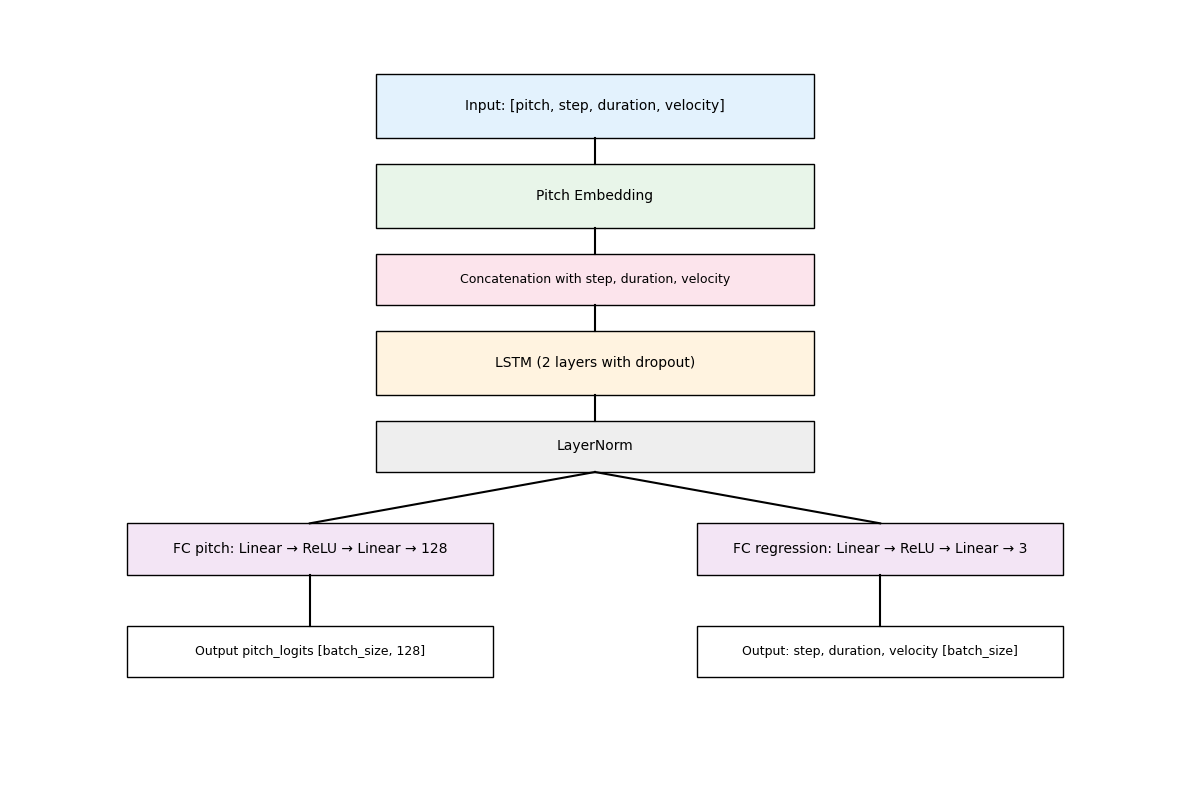

In [14]:
# =================== Instantiate model, loss function, and optimizer ===================

# Create an instance of the LSTM model with the defined parameters
model = LSTMModel(hidden_size=hidden_size, lstm_layers=lstm_layers, dropout=dropout)
model.to(device)

# Print the model architecture
print(model)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Instantiate the loss function
criterion = MusicLoss(omega=omega, alpha=alpha, beta=beta, gamma=gamma)

# Print the total number of trainable parameters in the model
print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters()):,}')

# Plot the implemented architecture
DrawArchitecture()

Epoch 1/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 89.07it/s]


Epoch 1: Training Loss: 1.169, Validation Loss: 1.050
--------------------
Pitch: 0.89, Step: 0.0378, Duration: 0.04, Velocity: 0.0709
--------------------
[Best model saved as: state_mozart_]


Epoch 2/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 97.14it/s]


Epoch 2: Training Loss: 0.979, Validation Loss: 0.929
--------------------
Pitch: 0.79, Step: 0.0341, Duration: 0.04, Velocity: 0.0618
--------------------
[Best model saved as: state_mozart_]


Epoch 3/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 96.96it/s]


Epoch 3: Training Loss: 0.913, Validation Loss: 0.887
[Best model saved as: state_mozart_]


Epoch 4/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 97.47it/s]


Epoch 4: Training Loss: 0.891, Validation Loss: 0.877
[Best model saved as: state_mozart_]


Epoch 5/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 97.35it/s]


Epoch 5: Training Loss: 0.877, Validation Loss: 0.862
[Best model saved as: state_mozart_]


Epoch 6/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 97.16it/s]


Epoch 6: Training Loss: 0.862, Validation Loss: 0.856
--------------------
Pitch: 0.77, Step: 0.0499, Duration: 0.03, Velocity: 0.0487
--------------------
[Best model saved as: state_mozart_]


Epoch 7/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 96.81it/s]


Epoch 7: Training Loss: 0.853, Validation Loss: 0.838
[Best model saved as: state_mozart_]


Epoch 8/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 96.73it/s]


Epoch 8: Training Loss: 0.845, Validation Loss: 0.837


Epoch 9/200: 100%|████████████████████████████████████████████████| 430/430 [00:04<00:00, 96.85it/s]


Epoch 9: Training Loss: 0.836, Validation Loss: 0.832
[Best model saved as: state_mozart_]


Epoch 10/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.73it/s]


Epoch 10: Training Loss: 0.829, Validation Loss: 0.817
[Best model saved as: state_mozart_]


Epoch 11/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.21it/s]


Epoch 11: Training Loss: 0.824, Validation Loss: 0.816
--------------------
Pitch: 0.73, Step: 0.0344, Duration: 0.03, Velocity: 0.0412
--------------------


Epoch 12/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.44it/s]


Epoch 12: Training Loss: 0.818, Validation Loss: 0.810
[Best model saved as: state_mozart_]


Epoch 13/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.89it/s]


Epoch 13: Training Loss: 0.813, Validation Loss: 0.808


Epoch 14/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.20it/s]


Epoch 14: Training Loss: 0.808, Validation Loss: 0.800
[Best model saved as: state_mozart_]


Epoch 15/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.47it/s]


Epoch 15: Training Loss: 0.804, Validation Loss: 0.798


Epoch 16/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.05it/s]


Epoch 16: Training Loss: 0.799, Validation Loss: 0.797
--------------------
Pitch: 0.70, Step: 0.0296, Duration: 0.03, Velocity: 0.0389
--------------------


Epoch 17/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.24it/s]


Epoch 17: Training Loss: 0.793, Validation Loss: 0.789
[Best model saved as: state_mozart_]


Epoch 18/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.54it/s]


Epoch 18: Training Loss: 0.791, Validation Loss: 0.792


Epoch 19/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.14it/s]


Epoch 19: Training Loss: 0.788, Validation Loss: 0.796


Epoch 20/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.04it/s]


Epoch 20: Training Loss: 0.784, Validation Loss: 0.780
[Best model saved as: state_mozart_]


Epoch 21/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.11it/s]


Epoch 21: Training Loss: 0.779, Validation Loss: 0.779
--------------------
Pitch: 0.68, Step: 0.0322, Duration: 0.03, Velocity: 0.0401
--------------------


Epoch 22/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.92it/s]


Epoch 22: Training Loss: 0.775, Validation Loss: 0.779


Epoch 23/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.29it/s]


Epoch 23: Training Loss: 0.773, Validation Loss: 0.777


Epoch 24/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.75it/s]


Epoch 24: Training Loss: 0.766, Validation Loss: 0.771
[Best model saved as: state_mozart_]


Epoch 25/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.38it/s]


Epoch 25: Training Loss: 0.763, Validation Loss: 0.766


Epoch 26/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.71it/s]


Epoch 26: Training Loss: 0.761, Validation Loss: 0.766
--------------------
Pitch: 0.67, Step: 0.0287, Duration: 0.03, Velocity: 0.0376
--------------------


Epoch 27/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.91it/s]


Epoch 27: Training Loss: 0.755, Validation Loss: 0.760
[Best model saved as: state_mozart_]


Epoch 28/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.03it/s]


Epoch 28: Training Loss: 0.752, Validation Loss: 0.759


Epoch 29/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.67it/s]


Epoch 29: Training Loss: 0.748, Validation Loss: 0.755
[Best model saved as: state_mozart_]


Epoch 30/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.39it/s]


Epoch 30: Training Loss: 0.745, Validation Loss: 0.753


Epoch 31/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.75it/s]


Epoch 31: Training Loss: 0.739, Validation Loss: 0.752
--------------------
Pitch: 0.67, Step: 0.0331, Duration: 0.03, Velocity: 0.0366
--------------------


Epoch 32/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.81it/s]


Epoch 32: Training Loss: 0.735, Validation Loss: 0.748
[Best model saved as: state_mozart_]


Epoch 33/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.07it/s]


Epoch 33: Training Loss: 0.731, Validation Loss: 0.742
[Best model saved as: state_mozart_]


Epoch 34/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.07it/s]


Epoch 34: Training Loss: 0.725, Validation Loss: 0.736
[Best model saved as: state_mozart_]


Epoch 35/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.26it/s]


Epoch 35: Training Loss: 0.725, Validation Loss: 0.735


Epoch 36/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.88it/s]


Epoch 36: Training Loss: 0.718, Validation Loss: 0.730
--------------------
Pitch: 0.65, Step: 0.0292, Duration: 0.03, Velocity: 0.0387
--------------------
[Best model saved as: state_mozart_]


Epoch 37/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.68it/s]


Epoch 37: Training Loss: 0.713, Validation Loss: 0.733


Epoch 38/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.99it/s]


Epoch 38: Training Loss: 0.708, Validation Loss: 0.727


Epoch 39/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.48it/s]


Epoch 39: Training Loss: 0.705, Validation Loss: 0.726


Epoch 40/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.86it/s]


Epoch 40: Training Loss: 0.702, Validation Loss: 0.719
[Best model saved as: state_mozart_]


Epoch 41/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.37it/s]


Epoch 41: Training Loss: 0.697, Validation Loss: 0.714
--------------------
Pitch: 0.65, Step: 0.0314, Duration: 0.03, Velocity: 0.0382
--------------------
[Best model saved as: state_mozart_]


Epoch 42/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.71it/s]


Epoch 42: Training Loss: 0.692, Validation Loss: 0.708
[Best model saved as: state_mozart_]


Epoch 43/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.16it/s]


Epoch 43: Training Loss: 0.690, Validation Loss: 0.709


Epoch 44/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.21it/s]


Epoch 44: Training Loss: 0.686, Validation Loss: 0.706


Epoch 45/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.12it/s]


Epoch 45: Training Loss: 0.684, Validation Loss: 0.711


Epoch 46/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.42it/s]


Epoch 46: Training Loss: 0.679, Validation Loss: 0.706
--------------------
Pitch: 0.62, Step: 0.0301, Duration: 0.03, Velocity: 0.0382
--------------------


Epoch 47/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.60it/s]


Epoch 47: Training Loss: 0.675, Validation Loss: 0.699
[Best model saved as: state_mozart_]


Epoch 48/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.68it/s]


Epoch 48: Training Loss: 0.671, Validation Loss: 0.698


Epoch 49/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.09it/s]


Epoch 49: Training Loss: 0.671, Validation Loss: 0.695


Epoch 50/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.80it/s]


Epoch 50: Training Loss: 0.665, Validation Loss: 0.692
[Best model saved as: state_mozart_]


Epoch 51/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.05it/s]


Epoch 51: Training Loss: 0.661, Validation Loss: 0.692
--------------------
Pitch: 0.65, Step: 0.0277, Duration: 0.03, Velocity: 0.0413
--------------------


Epoch 52/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.88it/s]


Epoch 52: Training Loss: 0.659, Validation Loss: 0.693


Epoch 53/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.54it/s]


Epoch 53: Training Loss: 0.656, Validation Loss: 0.692


Epoch 54/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.78it/s]


Epoch 54: Training Loss: 0.650, Validation Loss: 0.687
[Best model saved as: state_mozart_]


Epoch 55/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 94.37it/s]


Epoch 55: Training Loss: 0.649, Validation Loss: 0.685


Epoch 56/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 94.79it/s]


Epoch 56: Training Loss: 0.647, Validation Loss: 0.680
--------------------
Pitch: 0.62, Step: 0.0283, Duration: 0.03, Velocity: 0.0407
--------------------
[Best model saved as: state_mozart_]


Epoch 57/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.84it/s]


Epoch 57: Training Loss: 0.641, Validation Loss: 0.680


Epoch 58/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 94.33it/s]


Epoch 58: Training Loss: 0.640, Validation Loss: 0.679


Epoch 59/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.51it/s]


Epoch 59: Training Loss: 0.638, Validation Loss: 0.679


Epoch 60/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.02it/s]


Epoch 60: Training Loss: 0.633, Validation Loss: 0.674
[Best model saved as: state_mozart_]


Epoch 61/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.34it/s]


Epoch 61: Training Loss: 0.631, Validation Loss: 0.676
--------------------
Pitch: 0.60, Step: 0.0275, Duration: 0.03, Velocity: 0.0455
--------------------


Epoch 62/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.27it/s]


Epoch 62: Training Loss: 0.626, Validation Loss: 0.675


Epoch 63/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.60it/s]


Epoch 63: Training Loss: 0.624, Validation Loss: 0.668
[Best model saved as: state_mozart_]


Epoch 64/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.92it/s]


Epoch 64: Training Loss: 0.623, Validation Loss: 0.666


Epoch 65/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.82it/s]


Epoch 65: Training Loss: 0.620, Validation Loss: 0.668


Epoch 66/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.80it/s]


Epoch 66: Training Loss: 0.618, Validation Loss: 0.664
--------------------
Pitch: 0.61, Step: 0.0285, Duration: 0.03, Velocity: 0.0410
--------------------


Epoch 67/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.96it/s]


Epoch 67: Training Loss: 0.614, Validation Loss: 0.665


Epoch 68/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.45it/s]


Epoch 68: Training Loss: 0.612, Validation Loss: 0.665


Epoch 69/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.60it/s]


Epoch 69: Training Loss: 0.608, Validation Loss: 0.663
[Best model saved as: state_mozart_]


Epoch 70/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 98.11it/s]


Epoch 70: Training Loss: 0.605, Validation Loss: 0.661


Epoch 71/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.97it/s]


Epoch 71: Training Loss: 0.604, Validation Loss: 0.655
--------------------
Pitch: 0.62, Step: 0.0256, Duration: 0.03, Velocity: 0.0377
--------------------
[Best model saved as: state_mozart_]


Epoch 72/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.89it/s]


Epoch 72: Training Loss: 0.603, Validation Loss: 0.653


Epoch 73/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.87it/s]


Epoch 73: Training Loss: 0.599, Validation Loss: 0.659


Epoch 74/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.77it/s]


Epoch 74: Training Loss: 0.594, Validation Loss: 0.654


Epoch 75/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.43it/s]


Epoch 75: Training Loss: 0.592, Validation Loss: 0.652


Epoch 76/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.50it/s]


Epoch 76: Training Loss: 0.591, Validation Loss: 0.649
--------------------
Pitch: 0.61, Step: 0.0267, Duration: 0.03, Velocity: 0.0434
--------------------
[Best model saved as: state_mozart_]


Epoch 77/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.31it/s]


Epoch 77: Training Loss: 0.588, Validation Loss: 0.650


Epoch 78/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.95it/s]


Epoch 78: Training Loss: 0.586, Validation Loss: 0.651


Epoch 79/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.34it/s]


Epoch 79: Training Loss: 0.583, Validation Loss: 0.653


Epoch 80/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.51it/s]


Epoch 80: Training Loss: 0.582, Validation Loss: 0.651


Epoch 81/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.62it/s]


Epoch 81: Training Loss: 0.579, Validation Loss: 0.646
--------------------
Pitch: 0.65, Step: 0.0251, Duration: 0.03, Velocity: 0.0388
--------------------


Epoch 82/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.44it/s]


Epoch 82: Training Loss: 0.576, Validation Loss: 0.649


Epoch 83/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.90it/s]


Epoch 83: Training Loss: 0.574, Validation Loss: 0.641
[Best model saved as: state_mozart_]


Epoch 84/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.67it/s]


Epoch 84: Training Loss: 0.572, Validation Loss: 0.647


Epoch 85/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.24it/s]


Epoch 85: Training Loss: 0.572, Validation Loss: 0.644


Epoch 86/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.57it/s]


Epoch 86: Training Loss: 0.570, Validation Loss: 0.639
--------------------
Pitch: 0.66, Step: 0.0254, Duration: 0.03, Velocity: 0.0384
--------------------


Epoch 87/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.89it/s]


Epoch 87: Training Loss: 0.564, Validation Loss: 0.640


Epoch 88/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.54it/s]


Epoch 88: Training Loss: 0.564, Validation Loss: 0.641


Epoch 89/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.25it/s]


Epoch 89: Training Loss: 0.562, Validation Loss: 0.640


Epoch 90/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.72it/s]


Epoch 90: Training Loss: 0.560, Validation Loss: 0.635
[Best model saved as: state_mozart_]


Epoch 91/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.69it/s]


Epoch 91: Training Loss: 0.558, Validation Loss: 0.634
--------------------
Pitch: 0.70, Step: 0.0263, Duration: 0.03, Velocity: 0.0386
--------------------


Epoch 92/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.67it/s]


Epoch 92: Training Loss: 0.556, Validation Loss: 0.636


Epoch 93/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 95.62it/s]


Epoch 93: Training Loss: 0.558, Validation Loss: 0.634


Epoch 94/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.89it/s]


Epoch 94: Training Loss: 0.550, Validation Loss: 0.633


Epoch 95/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.78it/s]


Epoch 95: Training Loss: 0.553, Validation Loss: 0.631


Epoch 96/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 96.36it/s]


Epoch 96: Training Loss: 0.546, Validation Loss: 0.637
--------------------
Pitch: 0.68, Step: 0.0263, Duration: 0.03, Velocity: 0.0374
--------------------


Epoch 97/200: 100%|███████████████████████████████████████████████| 430/430 [00:04<00:00, 97.39it/s]


Epoch 97: Training Loss: 0.546, Validation Loss: 0.632
Early stopping triggered!


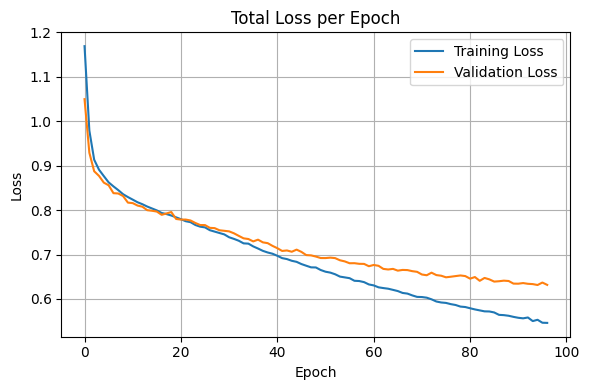

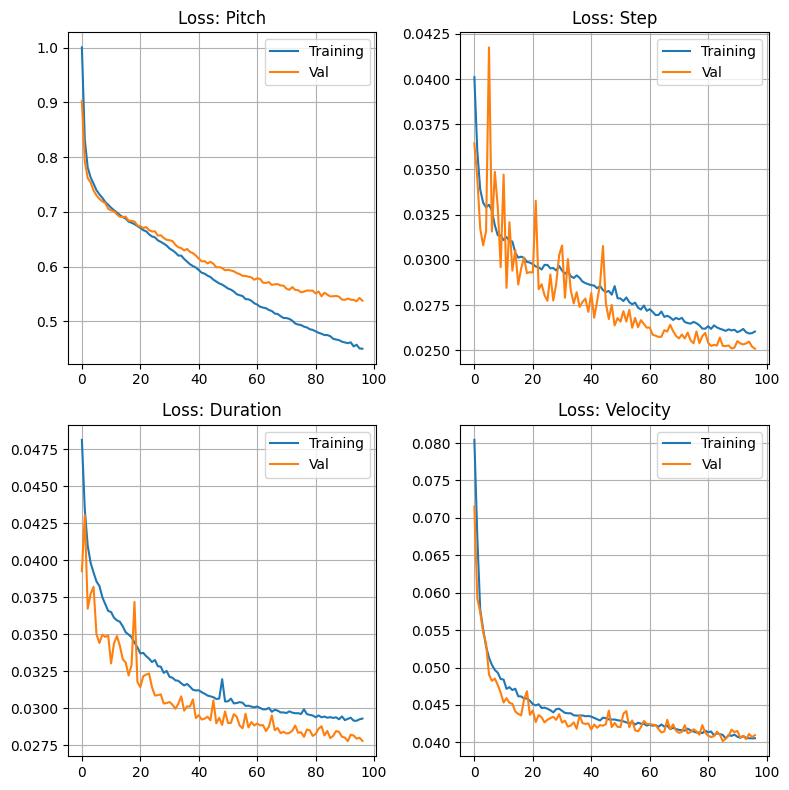

In [15]:
# =================== Run training or load a pre-trained model ===================
if train_new_model:

    loss_history_train, loss_history_val, model = train_model(model,
                                                              dataloader_train,
                                                              dataloader_val,
                                                              criterion,
                                                              optimizer,
                                                              device=device,
                                                              total_epochs=epochs,
                                                              early_stopping=early_stopping,
                                                              min_epochs=min_epochs,
                                                              save_path=save_state_path)

    joblib.dump(model, save_model_path)  # Store the model in reusable format
else:
    model = joblib.load(load_path)  # Load a pre-trained model
    print(f'Model "{load_path}" loaded successfully')

### Generation Phase

Generation completed
 200 notes written to MIDI file: myTrack_1_04-15__02:04.mid
 200 notes written to MIDI file: seed_1_04-15__02:04.mid
******************************
Song # 1
******************************
Notes in seed: 200, Notes generated: 200


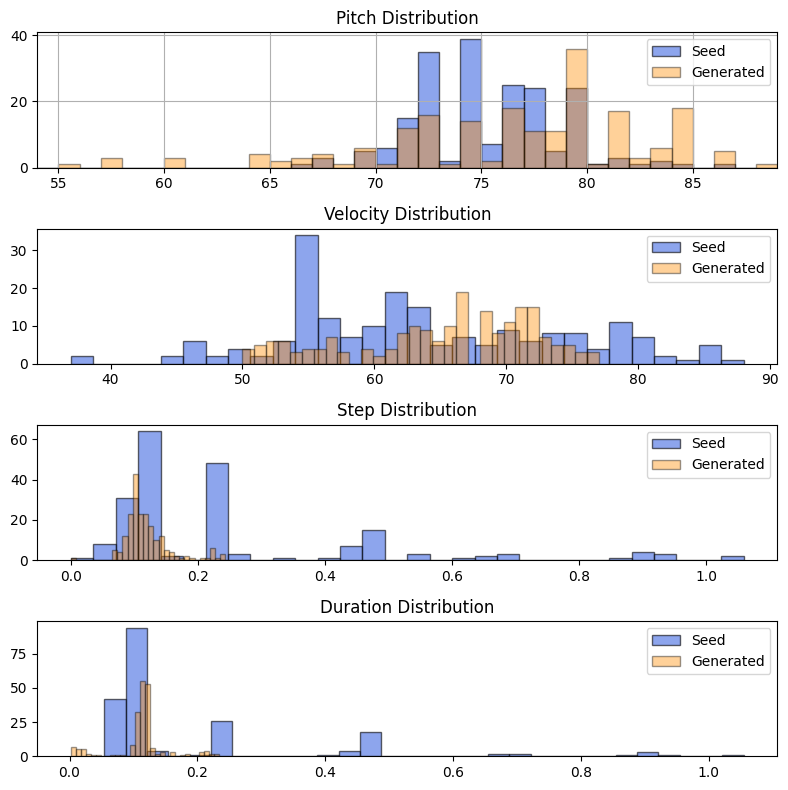

Generation completed
 200 notes written to MIDI file: myTrack_2_04-15__02:04.mid
 200 notes written to MIDI file: seed_2_04-15__02:04.mid
******************************
Song # 2
******************************
Notes in seed: 200, Notes generated: 200


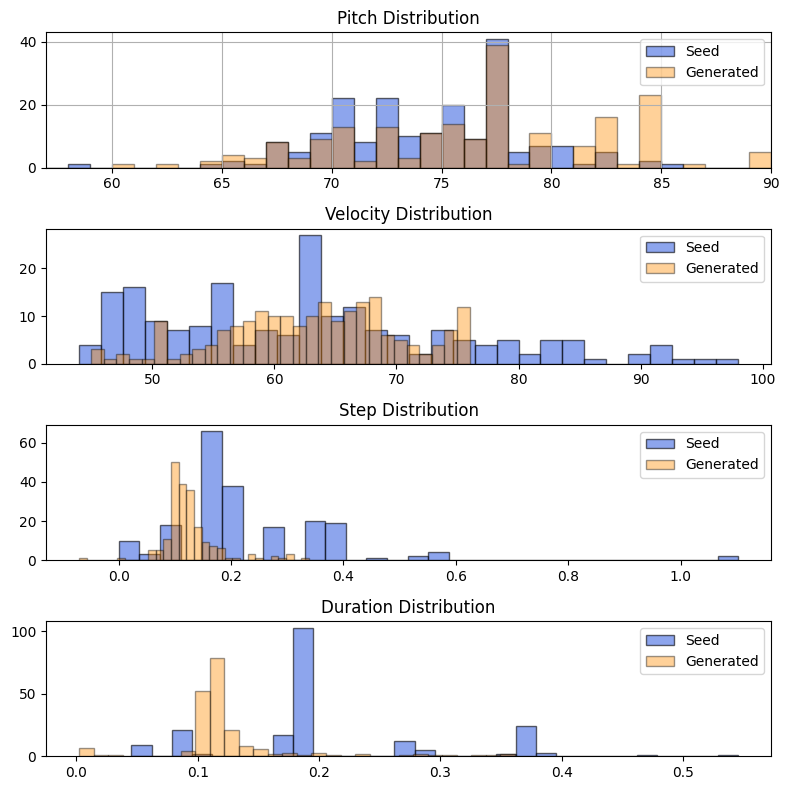

Generation completed
 200 notes written to MIDI file: myTrack_3_04-15__02:04.mid
 200 notes written to MIDI file: seed_3_04-15__02:04.mid
******************************
Song # 3
******************************
Notes in seed: 200, Notes generated: 200


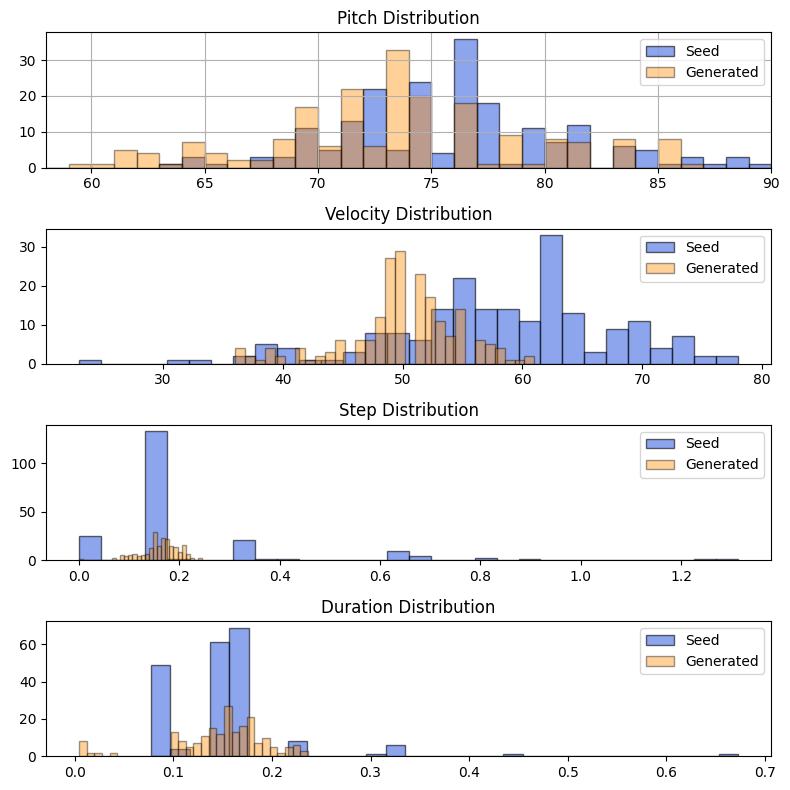

In [16]:
# =================== Sequence generation and statistics comparison ===================

# Load previously trained scalers to inverse transform 'step' and 'duration'
scaler_step = load('scalers/scaler_step.pkl')
scaler_duration = load('scalers/scaler_duration.pkl')

# Generate and evaluate 3 sequences using different seeds
for i in range(1, 4):
    random.seed(99 + i)  # Change the seed to obtain a different sequence each time
    seed, *_ = test_dataset[random.randint(0, len(test_dataset) - 1)]  # Random selection from test dataset

    # Generate new sequence from the seed
    newTrack = generateSequence(model, seed, device=device, temperature=temperature)

    # Define filenames with index and current timestamp
    timestamp = datetime.now().strftime("%m-%d__%H:%M")
    midi_save_path = f'myTrack_{i}_{timestamp}.mid'
    seed_save_path = f'seed_{i}_{timestamp}.mid'

    # Save the generated sequence and the seed as MIDI files
    seq2midi(newTrack, midi_save_path, scaler_step=scaler_step, scaler_duration=scaler_duration)
    seq2midi(seed, seed_save_path, scaler_step=scaler_step, scaler_duration=scaler_duration)

    # Compare statistics between the seed and the generated sequence
    print('*'*30)
    print(f"Song # {i}")
    print('*'*30)
    compare_midi_statistics(seed_save_path, midi_save_path)

In [17]:
pip freeze > requirements.txt # Export  the requirements file for deployment in other environments

Note: you may need to restart the kernel to use updated packages.
